In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
from datasets import Dataset
from llmft.generate_data.rtc import generate_dataset
import transformers
from torch.utils.data import DataLoader
import numpy as np 

In [2]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

512


In [4]:
def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

In [5]:
# original_dataset = Dataset.from_dict(generate_dataset(total_entries=1000, flip_rate=0.))
# dataset = original_dataset.train_test_split(test_size=0.5, seed=42)
# tokenized_dataset = dataset.map(tokenizer_function, batched=True)
# tokenized_dataset = tokenized_dataset.remove_columns("text")


original_dataset = load_dataset("ppower1/instrument")['train']
subset_dataset = original_dataset.shuffle(seed=42).select(range(1000))
dataset = subset_dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'treated text', 'control text', 'raw_label'])


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [6]:
def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

max(dataset['train'].map(count_tokens)['num_tokens'])

674

#### **Hyperparameters**

In [7]:
batch_size = 16
epochs = 20

#### **DataLoaders**

In [8]:
train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Optimizer and scheduler**

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_id)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(0.1*len(train_loader)*epochs), len(train_loader)*epochs)

In [11]:
# Initialize variables for callback simulation
best_loss = float('inf')
best_epoch = None
evaluated_at_first_step = False

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
def predict(model, data_loader):
    model.eval()  # Set the model to evaluation mode.
    predictions = []
    with torch.no_grad():  # No gradients needed for predictions.
        for batch in data_loader:
            # Assuming your batch only includes input data and not labels.
            batch = {k: v.to(device) for k, v in batch.items() if v.dtype in [torch.float32, torch.int64]}  # Move to device

            outputs = model(**batch).logits  # Get model outputs
            probs = torch.nn.functional.softmax(outputs, dim=1)[:,1]
            predictions.extend(probs.cpu().numpy())

    return np.array(predictions)

In [14]:
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [15]:
from torch import nn

# Assume 'class_counts' is a list containing the number of samples for each class
total_samples = sum(original_dataset['label'])
class_weights = torch.tensor([total_samples/ len(original_dataset), 1-total_samples/ len(original_dataset)], device=device)
print(f"Relative Weights: {class_weights}")

# Create a weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device),  batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits  # Extract logits from the model output
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    return average_loss


Relative Weights: tensor([0.0636, 0.9364], device='cuda:0')


In [16]:
evaluation_losses = [evaluate_model(model, test_loader, device)]
training_losses = [evaluate_model(model, train_loader, device)]
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(epochs):

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    training_losses.append(train_loss)
    
    val_loss = evaluate_model(model, test_loader, device)
    evaluation_losses.append(val_loss)
    
    # Call early stopping
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('checkpoint.pt'))


Validation loss decreased (inf --> 0.492625).  Saving model ...
Validation loss decreased (0.492625 --> 0.440664).  Saving model ...
Validation loss decreased (0.440664 --> 0.363726).  Saving model ...
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping


<All keys matched successfully>

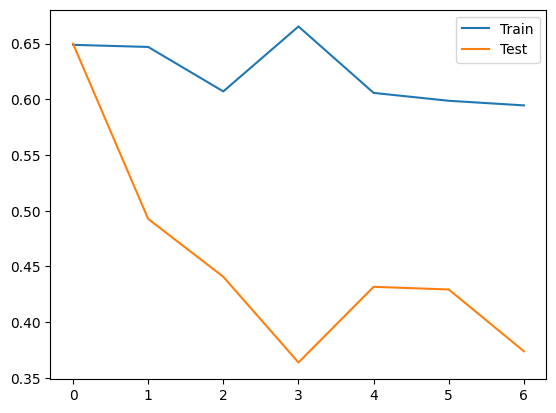

In [17]:
plt.plot(training_losses, label='Train')
plt.plot(evaluation_losses, label='Test')
plt.legend()
plt.show()

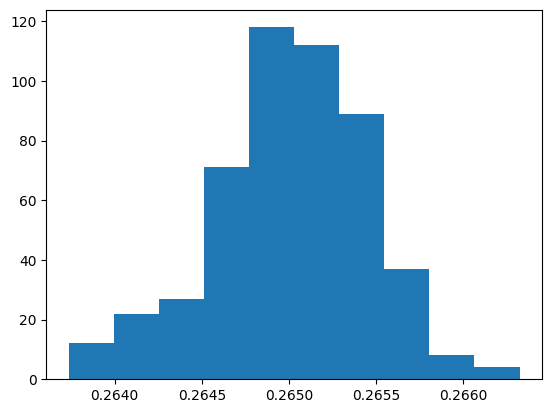

In [18]:
plt.hist(predict(model, train_loader))
plt.show()

In [19]:
np.sum(np.array(dataset['train']['label']))

20

In [20]:
dataset['train']['text'][:10]

["No, the Right to Counsel is not in effect in the tenant's zip code. The complaint filed by MATTA, LLC against Fatima F Alves and Richard S. Collazo states that MATTA, LLC is the owner of a property located at [ADDRESS] in Waterbury, Connecticut. The defendants have been leasing the premises on a month-to-month basis, and the lease has now expired. The plaintiff has given notice to the defendants on June 23, 2022, to vacate the premises by August 1, 2022. However, the defendants have failed to comply with the notice and continue to occupy the property. The plaintiff is seeking immediate possession of the premises and does not seek any monetary damages. The complaint was filed on August 2, 2022, and the return date is set for August 12, 2022. The complaint includes a copy of the notice to quit possession served on the defendants. True or False: The tenant has legal representation.",
 'No, the Right to Counsel is not in effect in the tenant\'s zip code. The complaint is a summons for a 

In [21]:
model(**tokenizer(dataset['train']['text'][0], return_tensors="pt").to('cuda'))

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.7080, -0.3166]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)